In [1]:
import csv
import pathlib
import cv2
import torch
import heapq
import shutil
import PIL
import glob
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt55
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.ticker as ticker
from collections import defaultdict
from matplotlib.font_manager import FontProperties
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# to mount to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/aksharantar_dataset/tel/'

/content/drive/MyDrive/aksharantar_dataset/tel


In [4]:
val_tsv_file = open("/content/drive/MyDrive/aksharantar_dataset/tel/tel_valid.csv")
tsv_file = open("/content/drive/MyDrive/aksharantar_dataset/tel/tel_train.csv")
test_tsv_file = open("/content/drive/MyDrive/aksharantar_dataset/tel/tel_test.csv")
val_read_tsv = csv.reader(val_tsv_file)
read_tsv = csv.reader(tsv_file)
test_read_tsv = csv.reader(test_tsv_file)

In [5]:
_pad, _space = "\t", "\n"
train_X, train_Y = [], []
for i in read_tsv:   
    train_Y.append(i[1])
    train_X.append(i[0])

test_Y, test_X = [], []
for i in test_read_tsv:
    test_Y.append(i[1])
    test_X.append(i[0])

val_X, val_Y = [], []
for i in val_read_tsv:
    val_Y.append(i[1])
    val_X.append(i[0])


trainsize=len(train_X)

In [6]:
train_X, train_Y = np.array(train_X), np.array(train_Y)
for i in range(train_Y.shape[0]):
    train_Y[i] = _pad + train_Y[i] + _space

test_X, test_Y = np.array(test_X), np.array(test_Y)
for i in range(test_Y.shape[0]):
    test_Y[i] = _pad + test_Y[i] + _space

val_X, val_Y = np.array(val_X), np.array(val_Y)
for i in range(val_Y.shape[0]):
    val_Y[i] = _pad + val_Y[i] + _space

In [7]:
val_output_corpus, output_corpus, val_input_corpus, input_corpus = set(), set(), set(), set()
d_type, td_type, c_end = "int64", torch.int64, " "
output_corpus, input_corpus = set(char for word in train_Y for char in word if char not in output_corpus), set(char for word in train_X for char in word if char not in input_corpus)

input_corpus.add(c_end)
output_corpus.add(c_end)

output_corpus, input_corpus = sorted(list(output_corpus)),  sorted(list(input_corpus))
num_decoder_tokens, num_encoder_tokens = len(output_corpus),  len(input_corpus)

max_decoder_seq_length, max_encoder_seq_length = max([len(txt) for txt in train_Y]), max([len(txt) for txt in train_X]) + 2
val_output_corpus, val_input_corpus = set(char for word in val_Y for char in word if char not in val_output_corpus), set(char for word in val_X for char in word if char not in val_input_corpus)

In [8]:
print("Max sequence length for outputs:", max_decoder_seq_length)
print("Number of unique output tokens:", num_decoder_tokens)

Max sequence length for outputs: 21
Number of unique output tokens: 65


In [9]:
ln_train, ln_val = len(train_X), len(val_X)
print("Number of samples:", len(train_X))
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Number of unique input tokens:", num_encoder_tokens)

Number of samples: 51200
Max sequence length for inputs: 30
Number of unique input tokens: 27


In [10]:
input_data = np.zeros((max_encoder_seq_length,ln_train), dtype= d_type)
target_data = np.zeros((max_decoder_seq_length,ln_train), dtype= d_type)
input_data_val = np.zeros((max_encoder_seq_length,ln_val), dtype= d_type)
target_data_val = np.zeros((max_decoder_seq_length,ln_val), dtype= d_type)

In [11]:
input_size_decoder = num_decoder_tokens
output_size = num_decoder_tokens
input_size_encoder = num_encoder_tokens

In [12]:
def create_char_index(corpus):
    char_index = defaultdict(int)
    for i, char in enumerate(corpus):
        ind_ = i
        if char not in char_index:
            char_index[char] = ind_
    return dict(char_index)

output_char_index, input_char_index = create_char_index(output_corpus), create_char_index(input_corpus)


In [13]:
for i in range(ln_train):
    y , x, count, count1 = train_Y[i], train_X[i], 0, 1
    for t, char in enumerate(x):
        input_data[t, i] = input_char_index[char]
    t_z = t+1
    input_data[t_z :,i], count = input_char_index[c_end], count + 1 

    for t, char in enumerate(y):
        target_data[t, i] = output_char_index[char]
        count1 = count+1  
    t_z = t+1       
    target_data[t_z :,i] = output_char_index[c_end]
    
for i in range(ln_val):
    y, x, count = val_Y[i], val_X[i], 0
    for t, char in enumerate(x):
        input_data_val[t, i], count = input_char_index[char], count +1
    t_z = t+1
    input_data_val[t_z :,i] = input_char_index[c_end]
    
    count = 0
    for t, char in enumerate(y):
        target_data_val[t, i], count = output_char_index[char], count +1
    t_z = t+1        
    target_data_val[t_z :,i] = output_char_index[c_end]



In [14]:
# Reverse-lookup token index to decode sequences back to
# something readable.
input_data, input_data_val, target_data, target_data_val = torch.tensor(input_data,dtype = td_type), torch.tensor(input_data_val,dtype = td_type), torch.tensor(target_data,dtype = td_type), torch.tensor(target_data_val,dtype = td_type)
reverse_input_char_index = {i: char for char, i in input_char_index.items()}
reverse_target_char_index = {i: char for char, i in output_char_index.items()}

In [15]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index, reverse_target_char_index = dict((i, char) for char, i in input_char_index.items()), dict((i, char) for char, i in output_char_index.items())
input_size_decoder, output_size, input_size_encoder = num_decoder_tokens, num_decoder_tokens, num_encoder_tokens

In [16]:
class DecoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
        super(DecoderGRU, self).__init__()
        drop_par, emb_size = dropout, embedding_size
        self.dropout = nn.Dropout(drop_par)
        self.num_layers, self.hidden_size, inp = num_layers, hidden_size, input_size
        gru_par = hidden_size * 2 + emb_size
        self.embedding = nn.Embedding(inp, emb_size)
        self.rnn = nn.GRU(gru_par, hidden_size, num_layers)
        lin_par, s_dim = hidden_size * 3, 0
        self.energy = nn.Linear(lin_par, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim = s_dim)
        self.relu = nn.Hardshrink()

    def forward(self, x, encoder_states, hidden):
        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(0)
        drop_par, sequence_length = self.embedding(x), encoder_states.shape[0]
        r_dim = 2
        embedding = self.dropout(drop_par)
        # embedding shape: (1, N, embedding_size)
        
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)
        relu_par = torch.cat((h_reshaped, encoder_states), dim = r_dim)
        energy = self.relu(self.energy(relu_par))
        # energy: (seq_length, N, 1)
        
        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)
        encoder_states = encoder_states.permute(1,0,2)

        attention = attention.permute(1,2,0)
        # attention: (N, seq_length, 1)
        encoder_states = self.relu(encoder_states)
        # encoder_states: (N, seq_length, hidden_size*2)
        context_init = torch.bmm(attention, encoder_states)
        context_vector = context_init.permute(1,0,2)
        
        rnn_input = torch.cat((context_vector, self.dropout(drop_par)),dim = r_dim)
       # rnn_input = self.relu(rnn_input)
        outputs, (hidden) = self.rnn(rnn_input, (hidden))
        # outputs shape: (1, N, hidden_size)

        #predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = self.fc(outputs).squeeze(0)

        return predictions, hidden, attention
class Seq2SeqGR(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqGR, self).__init__()
        self.decoder, self.encoder = decoder, encoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        target_len, target_vocab_size, batch_size = target.shape[0], num_decoder_tokens, source.shape[1]
        
        encoder_states, hidden = self.encoder(source)

         # Grab the first input to the Decoder which will be <SOS> token
        n_len, x = target.shape[0], target[0]
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

        for t in range(1, n_len):
            # Use previous hidden, cell as context from encoder at start
            output, hidden, _ = self.decoder(x, encoder_states, hidden)

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess, ind = output.argmax(1), t

            # Store next output prediction
            outputs[ind] = output

            x = best_guess if random.random() >= teacher_force_ratio else target[t]

        return outputs

class EncoderGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
        super(EncoderGRU, self).__init__()
        drop_par, emb_size, bidir = dropout, embedding_size, True
        self.dropout = nn.Dropout(drop_par)
        self.num_layers, self.hidden_size, inp = num_layers, hidden_size, input_size
        self.embedding = nn.Embedding(inp, emb_size)
        fc_lin_par = hidden_size * 2
        self.rnn = nn.GRU(embedding_size, hidden_size, num_layers, bidirectional = bidir)
        
        self.fc_hidden = nn.Linear(fc_lin_par, hidden_size)
        self.fc_cell = nn.Linear(fc_lin_par, hidden_size)

    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size
        drop_par, fc_dim  = self.embedding(x), 2
        embedding = self.dropout(drop_par)
        # embedding shape: (seq_length, N, embedding_size)
        
        encoder_states, hidden = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)
        fc_hidden_par = (hidden[0:1], hidden[1:2])
        fc_par = torch.cat(fc_hidden_par, dim = fc_dim)
        hidden = self.fc_hidden(fc_par)
        #cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden

In [17]:
num_epochs, dec_dropout = 40, 0.3
hidden_size, num_layers = 512, 1
beam_width, learning_rate =4, 0.001
batch_size, enc_dropout = 512, 0.1
encoder_embedding_size, decoder_embedding_size = 256, 256
criterion = nn.CrossEntropyLoss()

In [18]:
def beam_findGR(model, word, norm,input_char_index, output_char_index, reverse_input_char_index,reverse_target_char_index, 
                max_encoder_seq_length, max_decoder_seq_length,num_encoder_tokens, num_decoder_tokens, beam_width, device, length_penalty=0.6):

    word_val, word_t, attention, ln_word = 0, '', [], len(word)
    data = np.zeros((max_encoder_seq_length, 1), dtype= d_type)
    for t in range(ln_word):
        char = word[t]
        data[t, word_val] = input_char_index[char]
    word_size = ln_word
    data[ word_size:, word_val] = input_char_index[c_end]
    data = torch.tensor(data, dtype= td_type).to(device)

    with torch.no_grad():
        encoder_states,hidden = model.encoder(data)

    # Initialize beam
    
    value,  _dim = 1, 0
    initial_sequence = torch.tensor(np.array(output_char_index[_pad]).reshape(value,)).to(device)
    beam, res = [(0.0, initial_sequence, hidden.unsqueeze(0))], hidden.unsqueeze(0) # [(score, sequence, hidden)]
    best_res, _value = "", -1
    for _ in range(max_decoder_seq_length):
        options, candidates = [], []
        for score, seq, hidden in beam:
            last_token, count = seq[_value].item(), 0
            _total = 0
            if last_token == output_char_index[_space]:
                # If the sequence ends with the end token, add it to the candidates
                candidates.append((score, seq, hidden))
                count, _total =count+1, _total+1
                continue
          
            tempval, _total  = np.array(last_token).reshape(value,), 0
            x = torch.tensor(tempval).to(device)
            output, hidden,at = model.decoder(x,encoder_states ,hidden.squeeze(0))
            attention.append(at.detach().cpu().numpy())
            res, _total = output[0:], _total + count
            probabilities = F.softmax(output, dim=1)
            
            # Get the top-k probabilities and tokens
            topk_probs, topk_tokens = torch.topk(probabilities, k=beam_width)
            topk, tops = topk_tokens[0], topk_probs[0]
            result, _total, len_pen = probabilities, 0,  length_penalty
            for prob, token in zip(tops, topk):
                new_s, _dim = token.unsqueeze(0), 0
                new_seq = torch.cat((seq, new_s), dim = _dim)
                new_hidden = hidden.clone().unsqueeze(_dim)
                penalty = len(new_seq) - 1
                _score = score + torch.log(prob).item()
                length_penalty_factor = ((penalty) / 5) **  len_pen
                   # Adjust penalty factor as needed
                candidates.append((_score / length_penalty_factor, new_seq, new_hidden))
                options.append((_score / length_penalty_factor))
        # Select top-k candidates based on the accumulated scores
        beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[_dim])

    # Select the best sequence from the beam as the output
    best_score, best_sequence, _ = max(beam, key=lambda x: x[_dim])
    word_t = ''.join([reverse_target_char_index[token.item()] for token in best_sequence[value : _value]])
    best_res = word_t

    return word_t,attention


In [19]:
num_layers_dec, num_layers_enc, l_rate = 1, 1, learning_rate
enc_embedding_size, hidden_size_enc = encoder_embedding_size, hidden_size
dropout_dec, dropout_enc, dim_ = dec_dropout, enc_dropout, 1
input_size_dec, input_size_enc = input_size_decoder, input_size_encoder
hidden_size_dec, dec_embedding_size = hidden_size,  decoder_embedding_size


encoder_net = EncoderGRU(input_size_enc,enc_embedding_size, hidden_size_enc, num_layers_enc, dropout_enc).to(device)
decoder_net = DecoderGRU( input_size_dec,dec_embedding_size,hidden_size_dec,output_size,num_layers_dec,dropout_dec,).to(device)

model = Seq2SeqGR(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr = l_rate)

In [20]:
train_ds_y, train_ds_x = torch.split(target_data,batch_size,dim = dim_), torch.split(input_data,batch_size, dim = dim_)
count_ =0
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")
    model.eval()
    model.train()

    for i, (x,y) in enumerate(zip(train_ds_x,train_ds_y)):
        # Get input and targets and get to cuda
        target, inp_data = y.to(device),  x.to(device)
        count_ = count_ + 1
        # Forward prop
        output = model(inp_data, target)
        target, output = target[1:].reshape(-1), output[1:].reshape(-1, output.shape[2])
        optimizer.zero_grad()
        loss, count_ = criterion(output, target), 0
        # Back prop
        loss.backward()
        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = dim_)
        # Gradient descent step
        optimizer.step()
    correct_pred, total_words, correct_pred = 0, len(val_X), 0
    model.eval()
    for i in range(total_words):

        decoded_sentence,_ = beam_findGR(model,val_X[i], 10,input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                                         max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens,3,device)
        if decoded_sentence == val_Y[i][dim_:-1]:
            correct_pred = correct_pred + 1

    print(correct_pred / total_words) #test_accuracy = correct_pred / total_words


[Epoch 0 / 40]
0.069091796875
[Epoch 1 / 40]
0.2265625
[Epoch 2 / 40]
0.279541015625
[Epoch 3 / 40]
0.410888671875
[Epoch 4 / 40]
0.36572265625
[Epoch 5 / 40]
0.395751953125
[Epoch 6 / 40]
0.43408203125
[Epoch 7 / 40]
0.46484375
[Epoch 8 / 40]
0.4697265625
[Epoch 9 / 40]
0.48193359375
[Epoch 10 / 40]
0.505615234375
[Epoch 11 / 40]
0.478515625
[Epoch 12 / 40]
0.49755859375
[Epoch 13 / 40]
0.492431640625
[Epoch 14 / 40]
0.481689453125
[Epoch 15 / 40]
0.47705078125
[Epoch 16 / 40]
0.49267578125
[Epoch 17 / 40]
0.481689453125
[Epoch 18 / 40]
0.411376953125
[Epoch 19 / 40]
0.497802734375
[Epoch 20 / 40]
0.4853515625
[Epoch 21 / 40]
0.48779296875
[Epoch 22 / 40]
0.505859375
[Epoch 23 / 40]
0.50048828125
[Epoch 24 / 40]
0.49658203125
[Epoch 25 / 40]
0.482421875
[Epoch 26 / 40]
0.479736328125
[Epoch 27 / 40]
0.49853515625
[Epoch 28 / 40]
0.504150390625
[Epoch 29 / 40]
0.4951171875
[Epoch 30 / 40]
0.507080078125
[Epoch 31 / 40]
0.484375
[Epoch 32 / 40]
0.48193359375
[Epoch 33 / 40]
0.4802246093

In [74]:
total_words, correct_pred = len(test_X), 0
input, correct, decoded, ex = [], [], [], []

In [75]:
import matplotlib.colors

In [76]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, fig, seq_index, word, word_t):
    
    ax, _size, font_size, _init = fig.add_subplot(4, 3, seq_index), 20, 18, ''
    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["yellow","red"])
    cax = ax.matshow(attention, cmap = my_cmap, vmin = 0, vmax = 1)
    file_path = "/content/drive/MyDrive/aksharantar_dataset/tel/AnekTelugu[wdth,wght].ttf"
    font_prop_x = FontProperties(size = font_size)
    font_prop_y = FontProperties(fname = file_path, size = _size)

    ax.set_xticklabels([_init] + sentence,  fontproperties = font_prop_x)
    ax.set_yticklabels([_init] + predicted_sentence, fontproperties = font_prop_y)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(dim_))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(dim_))
    
    fig.colorbar(cax)


In [77]:
def plot_heatmap(model, word, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, max_encoder_seq_length,max_decoder_seq_length, 
                 num_encoder_tokens, num_decoder_tokens, device, fig, seq_index):
    attention, _res = [], 30
    word_t, at = beam_findGR(model,word, 10,input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                 max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens,3,device)
    out_set, inp_set = [], []
    for i in at:
        attention.append(i.reshape(_res,))
    attention = np.array(attention)
    ln_wt = len(word_t)
    for i in word_t:
        out_set.append(i)
    ln_w = len(word)
    for i in word:
        inp_set.append(i)
       
    plot_attention(attention[0:ln_wt , 0:ln_w], inp_set, out_set, fig, seq_index, word, word_t)

<ipython-input-76-24853d892ad4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([_init] + sentence,  fontproperties = font_prop_x)
<ipython-input-76-24853d892ad4>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([_init] + predicted_sentence, fontproperties = font_prop_y)


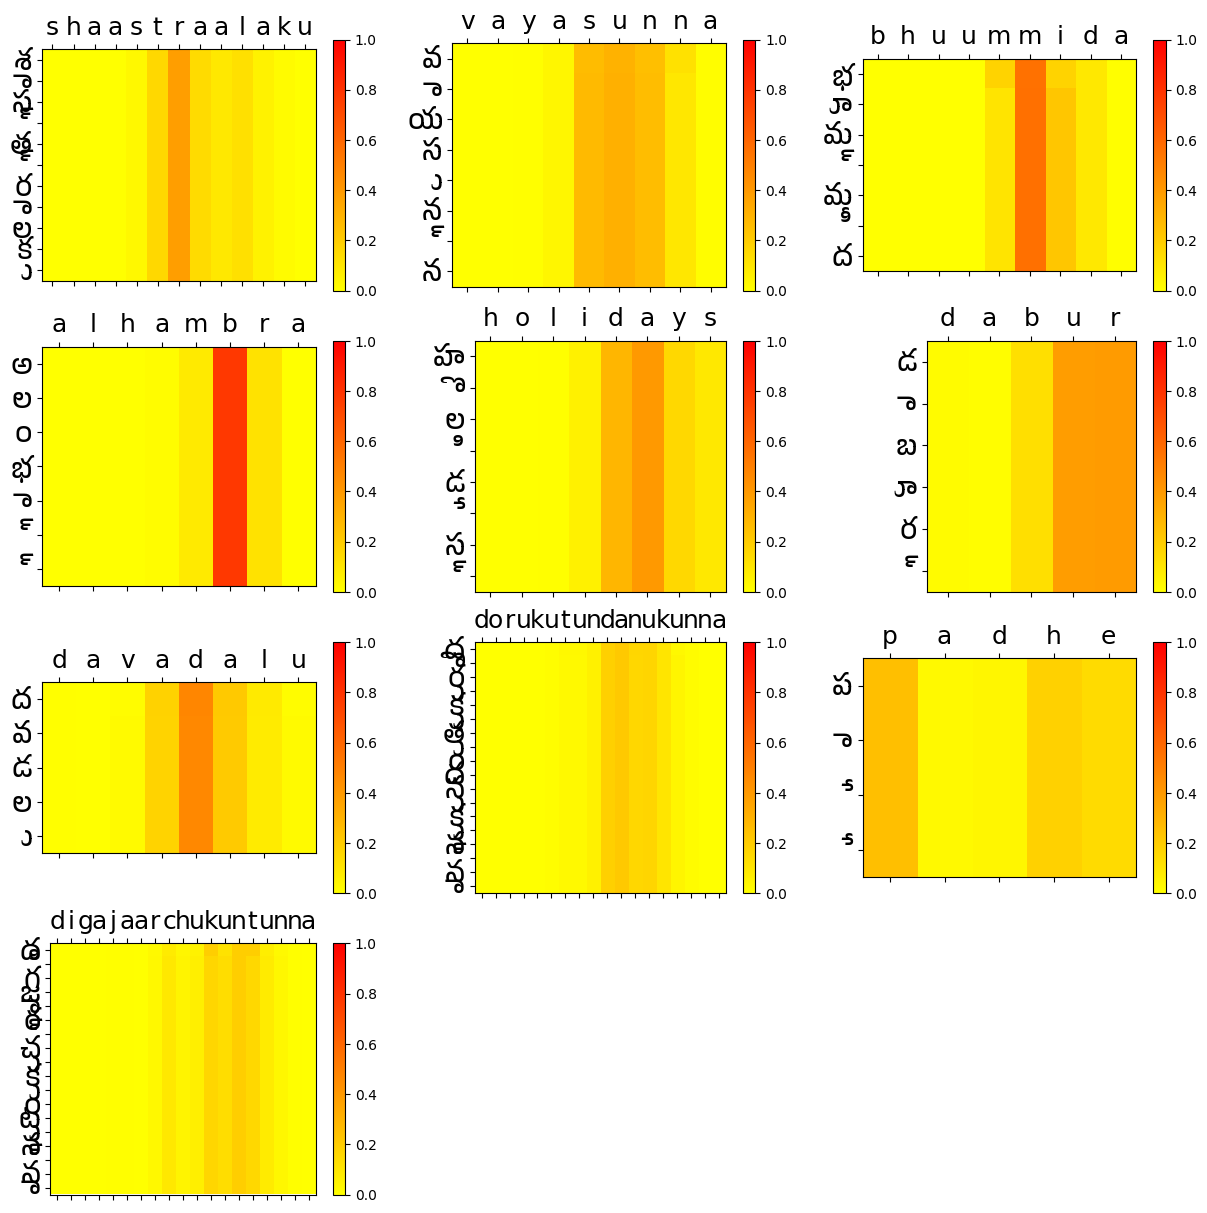

In [84]:
ln_test, inp_epoch = len(test_X), 10
np.random.seed(10)
fig = plt.figure(figsize=(15, 15))
for i in range(inp_epoch):
    seq_index = random.randint(0,ln_test)
    input_seq= test_X[seq_index]

    plot_heatmap(model, input_seq, input_char_index, output_char_index, reverse_input_char_index, reverse_target_char_index, 
                max_encoder_seq_length, max_decoder_seq_length, num_encoder_tokens, num_decoder_tokens, device, fig, i+1)
    